<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw8/nn_hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## _[NN HW8](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/05-nlp/03-transfer-learning/HomeWork.ipynb "NN HW8")_

Обучите модель на базе любого модуля из https://github.com/scikit-learn/scikit-learn/tree/master/sklearn предсказывать последовательность слов(кода)

---

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

import keras.utils as ku
import keras.layers as L
import keras.callbacks as C

Using TensorFlow backend.


##1.  _Подготовка данных_

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Будем обучать на модуле [sklearn.linear_model](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model "sklearn.linear_model: Generalized Linear Models")

In [4]:
%%bash

ls -hAlF sklearn/linear_model

total 692K
-rw-r--r-- 1 197609 197609  21K May 18 16:39 base.py
-rw-r--r-- 1 197609 197609  25K May 18 16:39 bayes.py
-rw-r--r-- 1 197609 197609  29K May 18 16:39 cd_fast.pyx
-rw-r--r-- 1 197609 197609  88K May 18 16:39 coordinate_descent.py
-rw-r--r-- 1 197609 197609  12K May 18 16:39 huber.py
-rw-r--r-- 1 197609 197609 3.0K May 18 16:39 __init__.py
-rw-r--r-- 1 197609 197609  70K May 18 16:39 least_angle.py
-rw-r--r-- 1 197609 197609  93K May 18 16:39 logistic.py
-rw-r--r-- 1 197609 197609  33K May 18 16:39 omp.py
-rw-r--r-- 1 197609 197609  18K May 18 16:39 passive_aggressive.py
-rw-r--r-- 1 197609 197609 6.1K May 18 16:39 perceptron.py
-rw-r--r-- 1 197609 197609  20K May 18 16:39 ransac.py
-rw-r--r-- 1 197609 197609  72K May 18 16:39 ridge.py
-rw-r--r-- 1 197609 197609  31K May 18 16:39 sag_fast.pyx.tp
-rw-r--r-- 1 197609 197609  14K May 18 16:39 sag.py
-rw-r--r-- 1 197609 197609 1.6K May 18 16:39 setup.py
-rw-r--r-- 1 197609 197609  630 May 18 16:39 sgd_fast_helpers.h
-rw-r--r-- 1

Выбираем только файлы `*.py`

In [5]:
pyfiles = glob.glob('sklearn/linear_model/**/*.py', recursive=True)

pyfiles

['sklearn/linear_model/perceptron.py',
 'sklearn/linear_model/__init__.py',
 'sklearn/linear_model/huber.py',
 'sklearn/linear_model/sag.py',
 'sklearn/linear_model/ransac.py',
 'sklearn/linear_model/least_angle.py',
 'sklearn/linear_model/logistic.py',
 'sklearn/linear_model/ridge.py',
 'sklearn/linear_model/base.py',
 'sklearn/linear_model/theil_sen.py',
 'sklearn/linear_model/coordinate_descent.py',
 'sklearn/linear_model/bayes.py',
 'sklearn/linear_model/stochastic_gradient.py',
 'sklearn/linear_model/passive_aggressive.py',
 'sklearn/linear_model/omp.py',
 'sklearn/linear_model/setup.py',
 'sklearn/linear_model/tests/test_passive_aggressive.py',
 'sklearn/linear_model/tests/test_omp.py',
 'sklearn/linear_model/tests/test_least_angle.py',
 'sklearn/linear_model/tests/__init__.py',
 'sklearn/linear_model/tests/test_ransac.py',
 'sklearn/linear_model/tests/test_logistic.py',
 'sklearn/linear_model/tests/test_coordinate_descent.py',
 'sklearn/linear_model/tests/test_base.py',
 'sklear

Генератор возвращает токенайзеру все строки каждого файла.

Отбросим ведущие пробелы в строке (отступы в коде) и далее будем брать текст строки до конца целиком.

*Соображения насчёт [комментариев](https://docs.python.org/3.7/reference/lexical_analysis.html?highlight=comments#comments "The Python Language Reference")*:

*   С одной стороны, можно было бы рассмотреть возможность удаления комментариев из кода. Но это не совсем тривиальная проблема, учитывая, что символ ***`#`*** может присутствовать внутри строкового литерала, а заниматься парснигом питоновского кода, очевидно, не хотелось бы.
*   С другой стороны, в простом случае, если ***`#`*** является первым не пустым символом в строке, то вроде как эту строку можно безопасно отбросить.
*   С третьей же стороны, в комментариях может содержаться полезная в нашем контексте информация, скажем, примеры вызовов функций.
*   А ещё есть [докстринги](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring "PEP 257 -- Docstring Conventions"))

В общем, в итоге я решил в данную проблему не углубляться и просто брать текст целиком.


In [0]:
def tokenizer_generator(files):
    for file in files:
        with open(file) as text:
            for line in text:
                line = line.lstrip()
                if 0 < len(line):
                    yield line

tok_gen = tokenizer_generator(pyfiles)

Токеном будет просто каждый символ в тексте:

In [0]:
tokenizer = Tokenizer(filters='', lower=False, char_level=True)

tokenizer.fit_on_texts(tok_gen)

In [8]:
print(len(tokenizer.index_word), tokenizer.document_count)

99 19186


In [0]:
def dataset_preparation(text_generator, tokenizer):
    total_words = len(tokenizer.word_index) + 1

    input_sequences = []
    for line in text_generator:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)

    return predictors, label, max_sequence_len, total_words

In [10]:
predictors, label, max_sequence_len, total_words = dataset_preparation(tokenizer_generator(pyfiles), tokenizer)

predictors.shape, label.shape, max_sequence_len, total_words

((732060, 82), (732060, 100), 83, 100)

## 2. _Модель_

Я понял задачу таким образом, что надо просто заоверфиттить модель так, чтобы она "запомнила" все возможные последовательности символов. Будем этого добиваться усложнением структуры сети (двунаправленный LSTM слой с большим количеством нейронов) и увеличением числа эпох обучения.

In [0]:
def create_model(predictors, label, max_sequence_len, total_words):

    model = Sequential()
    model.add(L.Embedding(total_words, 32, input_length=max_sequence_len-1))

    model.add(L.Bidirectional(L.LSTM(256, return_sequences=True)))
    model.add(L.Bidirectional(L.LSTM(128)))

    model.add(L.Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
earlystop = C.EarlyStopping(monitor='loss', min_delta=0.01, patience=2, verbose=0, mode='auto')
checkpoint = C.ModelCheckpoint('nn_hw8_model.{epoch:02d}-{acc:.2f}.h5', monitor='acc', 
                               verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model = create_model(predictors, label, max_sequence_len, total_words)

history = model.fit(predictors, label, batch_size=512, epochs=100, verbose=1, callbacks=[earlystop, checkpoint])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
732060/732060 [==============================] - 789s 1ms/step - loss: 2.5967 - acc: 0.3104
Epoch 2/100
732060/732060 [==============================] - 766s 1ms/step - loss: 1.4179 - acc: 0.6252
Epoch 3/100
732060/732060 [==============================] - 767s 1ms/step - loss: 1.0539 - acc: 0.7139
Epoch 4/100
732060/732060 [==============================] - 757s 1ms/step - loss: 0.8939 - acc: 0.7526
Epoch 5/100
732060/732060 [==============================] - 750s 1ms/step - loss: 0.7954 - acc: 0.7774
Epoch 6/100
732060/732060 [==============================] - 744s 1ms/step - loss: 0.7271 - acc: 0.7940
Epoch 7/100
732060/732060 [==============================] - 750s 1ms/step - loss: 0.6737 - acc: 0.8073
Epoch 8/100
732060/732060 [==============================] - 754s 1ms/step - loss: 0.6307 - acc: 0.8185
Epoch 9/100
732060/732060 [=====================

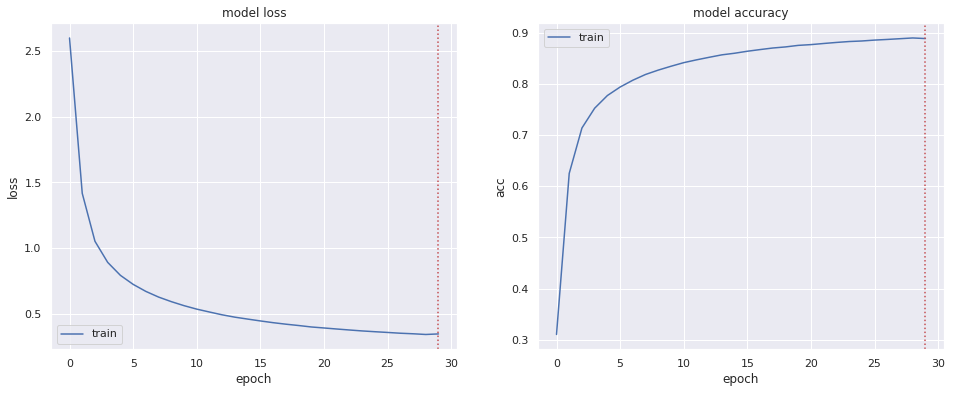

In [17]:
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    def plot_ax(ax, hist, title, train, loc='best'):
        ax.plot(hist[train])
        ax.axvline(x=len(hist[train])-1, color='r', linestyle=':')
        ax.set_title(title)
        ax.set_ylabel(train)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(0, len(hist[train]) + 1, 5))
        ax.legend(['train'], loc=loc)
        # ax.grid()
    plot_ax(ax[0], hist, 'model loss', 'loss')
    plot_ax(ax[1], hist, 'model accuracy', 'acc')

plot_history(history.history);

In [0]:
def save_model(model, basename):
    # serialize model to JSON
    model_json = model.to_json()
    with open(f'{basename}.json', 'w') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f'{basename}.h5')

In [30]:
save_model(model, 'nn_hw8_model_final')

!ls -hl nn_hw8_model_final.*

-rw-r--r-- 1 root root 4.9M May 24 11:56 nn_hw8_model_final.h5
-rw-r--r-- 1 root root 3.0K May 24 11:56 nn_hw8_model_final.json


## 3. _Предсказания_

Будем предсказывать следующий символ до момента появления перевода строки:

In [0]:
def generate_text(model, seed_text, max_sequence_len=max_sequence_len):
    for _ in range(max_sequence_len):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_char = tokenizer.index_word[predicted[0]]
        if output_char in '\r\n':
            break
        seed_text += output_char

    return seed_text

In [22]:
generate_text(model, 'fit')

'fit_intercept : bool'

In [23]:
generate_text(model, 'predict_')

'predict_scorer(X_scale, y_scale)'

In [24]:
generate_text(model, 'SGDC')

'SGDClassifier.linear RidgeClassifier(class_weight="balanced\'):'

In [25]:
generate_text(model, 'LinearR')

'LinearRegression, Cs = sqrt_alphas.Multiet_0.dtype'

In [26]:
generate_text(model, 'Logistic')

"LogisticRegression(C=len(iris.data), solver='liblinear', multi_class='ovr')"

In [27]:
generate_text(model, 'Per')

'Perceptron'

In [31]:
generate_text(model, 'SGDRe')

'SGDRegressor, SparseSGDRegressor])'

---

***TODO***: подумать, как можно было бы предсказывать более одного варианта, как это обычно и делается в инструментах [_code completion_](https://en.wikipedia.org/wiki/Intelligent_code_completion "Intelligent code completion").